# Loan Payback Prediction (Kaggle Playground S5E11)

## Project Overview
This project aims to predict whether a loan will be paid back using tabular
financial and demographic data.

The solution follows a full Kaggle-style machine learning pipeline, including:
- Unified preprocessing across train and test sets
- Out-of-fold (OOF) cross-validation
- Gradient boosting models and stacking
- ROC-AUC based evaluation for imbalanced classification


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression 

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier


## Data Loading

We load the training and test datasets provided by the Kaggle Playground
Series S5E11 competition.


In [2]:
train_path = "/kaggle/input/playground-series-s5e11/train.csv"
test_path  = "/kaggle/input/playground-series-s5e11/test.csv"

train = pd.read_csv(train_path)
test  = pd.read_csv(test_path)

print(train.shape, test.shape)
train.head()


(593994, 13) (254569, 12)


,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


## Target Definition

- Target variable: `loan_paid_back`
- This is a binary classification problem
- Labels are converted to integer format for model training


In [3]:
ID_COL = "id"
TARGET = "loan_paid_back"

y = train[TARGET].astype(int).values
train_ids = train[ID_COL].values
test_ids  = test[ID_COL].values


## Unified Preprocessing Strategy

To ensure consistent feature engineering, we concatenate the training
and test datasets and apply preprocessing steps jointly.


In [4]:
X_train = train.drop(columns=[TARGET])
X_test  = test.copy()

# Concatenate train and test features for consistent preprocessing
full = pd.concat([X_train, X_test], axis=0, ignore_index=True)

# Identify categorical columns (object / category types)
cat_cols = full.select_dtypes(include=["object", "category"]).columns.tolist()

# Identify numerical columns (excluding categorical columns and ID column)
num_cols = [c for c in full.columns if c not in cat_cols and c != ID_COL]

print("cat_cols:", len(cat_cols), cat_cols[:10])
print("num_cols:", len(num_cols), num_cols[:10])


cat_cols: 6 ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade']
num_cols: 5 ['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate']


The target variable is imbalanced,
which motivates the use of ROC-AUC as the evaluation metric
and stratified cross-validation.


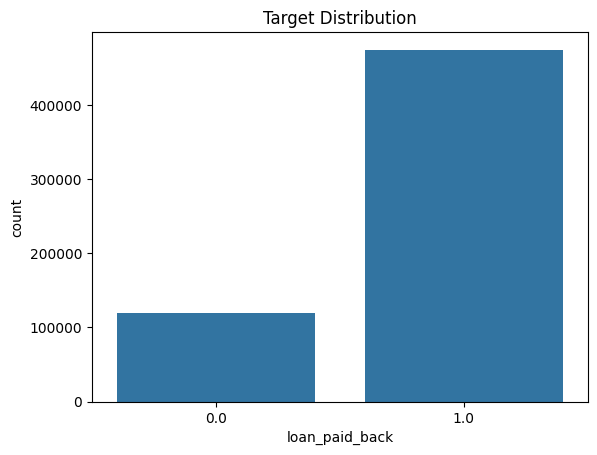

In [5]:
sns.countplot(x=train["loan_paid_back"])
plt.title("Target Distribution")
plt.show()


## Feature Engineering & Data Cleaning

This step handles:
- Missing value imputation for numerical and categorical features
- Encoding of categorical variables
- Preparation of the final feature matrix for modeling


In [6]:
full_proc = full.copy()

# Handle missing values in numerical features
for c in num_cols:
    full_proc[c] = full_proc[c].fillna(full_proc[c].median())

# Handle missing values in categorical features + label encoding
for c in cat_cols:
    full_proc[c] = full_proc[c].fillna("missing").astype(str)
    le = LabelEncoder()
    full_proc[c] = le.fit_transform(full_proc[c])

# Split back into train and test sets
Xtr = full_proc.iloc[:len(train)].copy()
Xte = full_proc.iloc[len(train):].copy()

# Drop ID column (not used as a feature)
if ID_COL in Xtr.columns:
    Xtr = Xtr.drop(columns=[ID_COL])
    Xte = Xte.drop(columns=[ID_COL])

Xtr.shape, Xte.shape


((593994, 11), (254569, 11))

## Out-of-Fold (OOF) Training Framework

We define a reusable OOF training function to:
- Perform K-Fold cross-validation
- Generate out-of-fold predictions for stacking
- Reduce overfitting and obtain reliable validation scores


In [7]:
def train_oof_model(model_name, build_model_fn, X, y, X_test, n_splits=5, seeds=(42, 2023)):
    oof = np.zeros(len(X))
    test_pred = np.zeros(len(X_test))
    all_scores = []

    for seed in seeds:
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
        oof_seed = np.zeros(len(X))
        test_seed = np.zeros(len(X_test))

        for fold, (tr_idx, va_idx) in enumerate(skf.split(X, y), 1):
            X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
            y_tr, y_va = y[tr_idx], y[va_idx]

            model = build_model_fn(seed)
            model.fit(X_tr, y_tr)

            va_pred = model.predict_proba(X_va)[:, 1]
            te_pred = model.predict_proba(X_test)[:, 1]

            oof_seed[va_idx] = va_pred
            test_seed += te_pred / n_splits

            auc = roc_auc_score(y_va, va_pred)
            print(f"[{model_name}] seed={seed} fold={fold} AUC={auc:.5f}")

        seed_auc = roc_auc_score(y, oof_seed)
        print(f"[{model_name}] seed={seed} OOF AUC={seed_auc:.5f}\n")

        oof += oof_seed / len(seeds)
        test_pred += test_seed / len(seeds)
        all_scores.append(seed_auc)

    final_auc = roc_auc_score(y, oof)
    print(f"[{model_name}] FINAL OOF AUC={final_auc:.5f} | seeds_auc={all_scores}")
    return oof, test_pred


## Base Model: LightGBM

LightGBM is used as a base learner due to its strong performance
on structured tabular data and efficiency in handling large feature spaces.


In [8]:
def build_lgb(seed):
    return lgb.LGBMClassifier(
        n_estimators=3000,
        learning_rate=0.02,
        num_leaves=64,
        max_depth=-1,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.0,
        reg_lambda=1.0,
        random_state=seed,
        n_jobs=-1
    )

def build_xgb(seed):
    return xgb.XGBClassifier(
        n_estimators=4000,
        learning_rate=0.02,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.0,
        reg_lambda=1.0,
        min_child_weight=1,
        gamma=0,
        objective="binary:logistic",
        eval_metric="auc",
        random_state=seed,
        tree_method="hist",
        n_jobs=-1
    )

def build_cat(seed):
    return CatBoostClassifier(
        iterations=6000,
        learning_rate=0.02,
        depth=8,
        loss_function="Logloss",
        eval_metric="AUC",
        random_seed=seed,
        verbose=0
    )

## Model Stacking

Out-of-fold predictions from multiple base models are combined
to train a meta-model, improving overall predictive performance.


In [9]:
oof_lgb, te_lgb = train_oof_model("LGB", build_lgb, Xtr, y, Xte, n_splits=5, seeds=(42, 2023))
oof_xgb, te_xgb = train_oof_model("XGB", build_xgb, Xtr, y, Xte, n_splits=5, seeds=(42, 2023))
oof_cat, te_cat = train_oof_model("CAT", build_cat, Xtr, y, Xte, n_splits=5, seeds=(42, 2023))

[LightGBM] [Info] Number of positive: 379595, number of negative: 95600
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1329
[LightGBM] [Info] Number of data points in the train set: 475195, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798819 -> initscore=1.378932
[LightGBM] [Info] Start training from score 1.378932
[LGB] seed=42 fold=1 AUC=0.92313
[LightGBM] [Info] Number of positive: 379595, number of negative: 95600
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008556 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1329
[LightGBM] [Info] Number of data points in the train set: 475195, number of u

## Model Evaluation

Model performance is evaluated using ROC-AUC, which is appropriate
for imbalanced binary classification problems.


In [10]:
meta_X = np.vstack([oof_lgb, oof_xgb, oof_cat]).T
meta_test = np.vstack([te_lgb, te_xgb, te_cat]).T

meta = LogisticRegression(max_iter=500)
meta.fit(meta_X, y)

oof_meta = meta.predict_proba(meta_X)[:, 1]
print("STACK OOF AUC:", roc_auc_score(y, oof_meta))

test_pred = meta.predict_proba(meta_test)[:, 1]


STACK OOF AUC: 0.9233544336232178


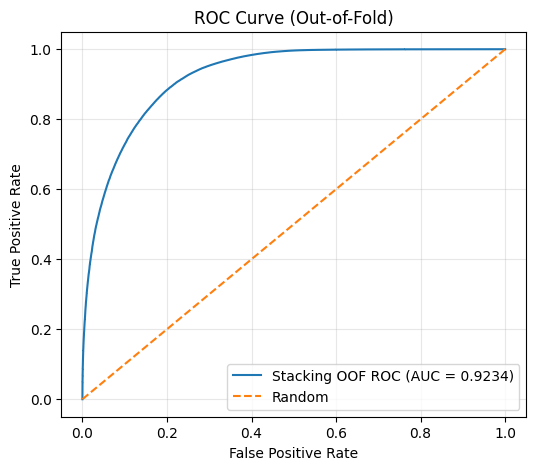

In [11]:
# ROC curve based on out-of-fold predictions
fpr, tpr, _ = roc_curve(y, oof_meta)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"Stacking OOF ROC (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Out-of-Fold)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

## Submission Generation

Final predictions on the test set are generated and saved
in the required submission format.


In [12]:
sub = pd.DataFrame({
    ID_COL: test_ids,
    TARGET: test_pred
})
sub.to_csv("submission.csv", index=False)
sub.head()


,id,loan_paid_back
0,593994,0.945298
1,593995,0.958465
2,593996,0.349573
3,593997,0.937428
4,593998,0.955639
